In [1]:
%matplotlib inline
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import cv2
import numpy as np
from transformers import DefaultDataCollator
from transformers import TFViTForImageClassification, create_optimizer
from IPython.display import HTML
from transformers import BitImageProcessor, BitForImageClassification
import torch
from datasets import load_dataset

2023-12-18 18:07:09.104525: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-18 18:07:09.248841: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-18 18:07:09.248868: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-18 18:07:09.272452: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-18 18:07:09.322291: I tensorflow/core/platform/cpu_feature_guar

# Import Data

In [2]:
train_folder = ImageFolder(root="train")
val_folder = ImageFolder(root="train")
test_set = ImageFolder(root="test")
train_set, val_set = torch.utils.data.random_split(train_folder, [0.8,0.2])
val_set.dataset = val_folder

## Define data augmentations
The images are augmented every time they are called. So for every epoch, an image is augmented in a different way.

In [3]:
transform_train = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.RandomRotation((-35, 35)),
    transforms.CenterCrop(size=(900, 900)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(brightness=.5, contrast=.2, hue=.2, saturation=.2),
    #transforms.RandomVerticalFlip(0.5),
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    #transforms.RandomErasing(1, scale=(0.1, 0.1), ratio=(1, 1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    
    
])
transform_val = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.CenterCrop(size=(900, 900)),
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_set.dataset.transform=transform_train
val_set.dataset.transform=transform_val
test_set.transform=transform_val

/home/jannik/miniconda3/envs/wsl_pt/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


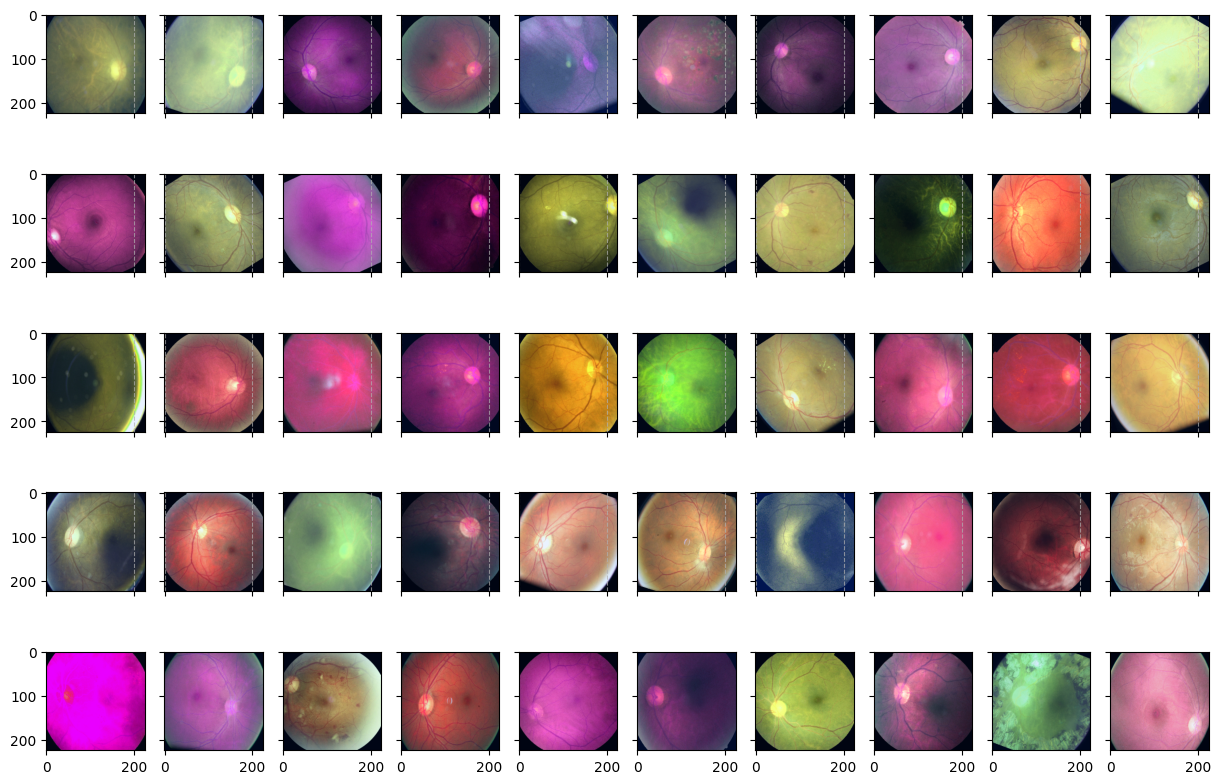

In [4]:

train_loader = DataLoader(train_set, batch_size=50, shuffle=True)

figs, axs = plt.subplots(5, 10, figsize=(15, 10))
for col in range(1, 10):
    for ax in axs[:, col]:
        ax.yaxis.set_ticklabels([])

# Set x-grid only for the lower subplots
for row in range(4):
    for ax in axs[row, :]:
        ax.xaxis.set_ticklabels([])
        ax.xaxis.grid(True, linestyle='--', alpha=0.7)
axs = axs.flatten()

for i, (inputs, labels) in enumerate(train_loader):
    if i < 1:
        for j in range(50):
            #bs, ncrops, c, h, w = inputs.size()

            #img = np.array(inputs.view(-1, c, h, w)[j].permute(1, 2, 0) )
            img = np.array(inputs[j].permute(1, 2, 0))
            img = (img - img.min()) / (img.max() - img.min())  # Broadcasting rules apply
            axs[j].imshow(img)

    else:
        break
plt.show()

# Model
The model used is google's Big Transfer model published in 2020 which is based on a ResNetV2.

In [5]:
# create optimizer wight weigh decay
model_name = "google/bit-50"
model = BitForImageClassification.from_pretrained(
    model_name,
    num_labels=len(train_folder.class_to_idx),
    id2label=train_folder.class_to_idx,
    label2id={v: k for k, v in train_folder.class_to_idx.items()},
    ignore_mismatched_sizes=True
)

Some weights of BitForImageClassification were not initialized from the model checkpoint at google/bit-50 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([5, 2048]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Train

In [6]:
from transformers import TrainingArguments

epochs = 30
bs = 64

training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=bs,
  evaluation_strategy="steps",
  num_train_epochs=epochs,
  fp16=True,
  save_steps=100,
  eval_steps=50,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='wandb',
  load_best_model_at_end=True,
)

In [7]:
from transformers import Trainer, EarlyStoppingCallback

processor = BitImageProcessor.from_pretrained(model_name)
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x[0] for x in batch]),
        'labels': torch.tensor([x[1] for x in batch])
    }

from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_set,
    eval_dataset=val_set,
    tokenizer=processor,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=5)]
)

/tmp/ipykernel_636/2086969060.py:12: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [8]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

wandb: Currently logged in as: jmettner (gmllm). Use `wandb login --relogin` to force relogin


/home/jannik/miniconda3/envs/wsl_pt/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Step,Training Loss,Validation Loss


/home/jannik/miniconda3/envs/wsl_pt/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/jannik/miniconda3/envs/wsl_pt/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to 

***** train metrics *****
  epoch                    =        23.53
  total_flos               = 1518775382GF
  train_loss               =       0.9954
  train_runtime            =   1:12:15.66
  train_samples_per_second =       22.585
  train_steps_per_second   =        0.353


In [9]:
metrics = trainer.evaluate(test_set)
trainer.log_metrics("test", metrics)
trainer.save_metrics("test", metrics)

/home/jannik/miniconda3/envs/wsl_pt/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


***** test metrics *****
  epoch                   =      23.53
  eval_accuracy           =      0.518
  eval_loss               =      1.052
  eval_runtime            = 0:00:08.31
  eval_samples_per_second =     60.099
  eval_steps_per_second   =      7.572


In [34]:
from PIL import Image

img0 = Image.open("test/0/102_left.jpeg")
img2 = Image.open("test/2/1002_right.jpeg")


ValueError: not enough values to unpack (expected 2, got 1)

In [76]:
import torch
from captum.attr import LayerGradCam
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [77]:
model.eval()
pass

In [78]:
img4 = Image.open("test/4/217_left.jpeg")
x = transform_val(img4)

In [80]:
target_layer

WeightStandardizedConv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)

In [177]:
import torch
from captum.attr import LayerGradCam, IntegratedGradients, Occlusion
from captum.attr import visualization as viz
from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature

# Assuming you have the necessary imports and the model is defined

img_gpu = x.unsqueeze(0).to("cpu")
model = model.to("cpu").eval()  # Ensure the model is in evaluation mode
#model.to(torch.long)
# Assuming 'logits' is the tensor containing class scores
#raw_output = model(img_gpu)
#logits = raw_output.to(torch.long).to("cpu")  # Adapt this based on your model's output structure

conv_layers = [module for module in model.modules() if isinstance(module, torch.nn.Conv2d)]
target_layer = conv_layers[-1]
layer_gc = IntegratedGradients(model)#, target_layer)

#img_gpu = torch.cat((img_gpu, img_gpu, img_gpu, img_gpu, img_gpu)).to(torch.long).to("cpu")
#target_class = torch.tensor([4]).unsqueeze(0).to(torch.long).to("cpu")

# Make sure the target_class is of the appropriate shape
#target_class = target_class.expand(img_gpu.size(0))

# Convert layer_gc.layer to the correct data type
#layer_gc.layer = layer_gc.layer.to(torch.long)

occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(img_gpu,
                                       target=[4],
                                       strides=(3, 8, 8),
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)


_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(img_gpu.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map", "heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6)
                                     )

AttributeError: 'ImageClassifierOutputWithNoAttention' object has no attribute 'shape'

In [174]:

visualizer.render()

CaptumInsights(insights_config={'classes': ['0', '1', '2', '3', '4'], 'methods': ['Deconvolution', 'Deep Lift'…

Output()

In [175]:
visualizer.render()

CaptumInsights(insights_config={'classes': ['0', '1', '2', '3', '4'], 'methods': ['Deconvolution', 'Deep Lift'…

Output()

In [ ]:
# Normalize the attributions to have values between 0 and 1
attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())

# Upsample the heatmap to the original image size
upsampled_attributions = transforms.ToPILImage()(torch.from_numpy(attributions)).resize((224, 224))

# Overlay the heatmap on the original image
original_image = Image.open("test/4/217_left.jpeg").convert('RGB')
overlay = Image.blend(original_image, upsampled_attributions, alpha=0.5)

# Plot the original image, heatmap, and overlay
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(attributions, cmap='viridis', alpha=0.8)
axes[1].set_title('Heatmap')
axes[2].imshow(overlay)
axes[2].set_title('Overlay')

plt.show()

In [176]:
visualizer.render()

CaptumInsights(insights_config={'classes': ['0', '1', '2', '3', '4'], 'methods': ['Deconvolution', 'Deep Lift'…

Output()